In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [ ]:
# 1️⃣ Load dataset
df_train = pd.read_csv("data/features/session_based_trainset.csv")
print("Training dataset shape:", df_train.shape)
df_test = pd.read_csv("data/features/session_based_testset.csv")
print("Testing dataset shape:", df_test.shape)

Training dataset shape: (488524, 280)
Testing dataset shape: (122132, 280)


In [ ]:
# 2️⃣ Use the correct label column
label_col = "label"
print("Unique values in label:", df_train[label_col].unique())
print("Unique values in label:", df_test[label_col].unique())

Unique values in label: [0 1]
Unique values in label: [1 0]


In [ ]:
# 3️⃣ Prepare features and target
y_raw = df_train[label_col]
X = df_train.drop(columns=[label_col]).fillna(0)

ytest_raw = df_test[label_col]
X_test = df_test.drop(columns=[label_col]).fillna(0) #new x test

In [25]:
# 4️⃣ Convert label text/numbers → binary
def map_label(val):
    val_str = str(val).lower()
    if "benign" in val_str or val == 0 or val == "0":
        return 0
    else:
        return 1

y = y_raw.apply(map_label)
y_test = ytest_raw.apply(map_label) #new y test
print("\nBinary label distribution in train set (0=Benign, 1=Malicious):\n", y.value_counts())
print("\nBinary label distribution in test set (0=Benign, 1=Malicious):\n", y_test.value_counts())


Binary label distribution in train set (0=Benign, 1=Malicious):
 label
1    245470
0    243054
Name: count, dtype: int64

Binary label distribution in test set (0=Benign, 1=Malicious):
 label
0    61273
1    60859
Name: count, dtype: int64


In [ ]:
# 5️⃣ Train/test split
'''X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("\nX Train:", X_train.shape, "X Test:", X_test.shape)'''

#no need to perform splits since there is an entire separate testing data set
X_train = X
y_train = y

In [22]:
# 6️⃣ Train Random Forest
rf = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

In [ ]:
# 7️⃣ Evaluate model
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))
print("ROC AUC:", round(roc_auc_score(y_test, y_proba), 4))
#the confusion matrix just below is showing correctly, but in the visualization it isn't showing bottom row correctly


Confusion Matrix:
[[61252    21]
 [  114 60745]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9981    0.9997    0.9989     61273
           1     0.9997    0.9981    0.9989     60859

    accuracy                         0.9989    122132
   macro avg     0.9989    0.9989    0.9989    122132
weighted avg     0.9989    0.9989    0.9989    122132

ROC AUC: 1.0


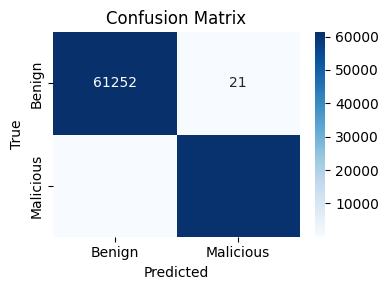

In [28]:
# 8️⃣ Visualize Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign", "Malicious"],
            yticklabels=["Benign", "Malicious"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


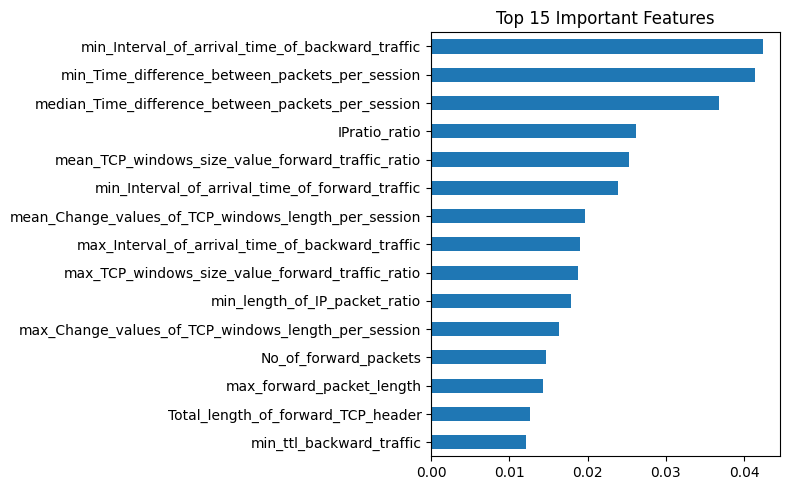

In [29]:
# 9️⃣ Feature Importance
imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8,5))
imp.head(15).plot(kind="barh", title="Top 15 Important Features")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [30]:
# 🔟 Save 
joblib.dump(rf, "report/rf_session_model.joblib")
imp.to_csv("report/rf_feature_importance.csv", index=True)
print("\nModel and feature importances saved in report/")


Model and feature importances saved in report/


In [32]:
# 11 Alternate data set testing setup
df = pd.read_csv("data/ton_iot/test1.csv")
label_col = "label"
print("Unique values in label:", df[label_col].unique())
y_raw = df[label_col]
X = df.drop(columns=[label_col]).fillna(0)
#there is an additional column that identifies either normal or type of attack, and keeping this in would skew training, so also drop
type_col = "type"
X = X.drop(columns=[type_col]).fillna(0)
#X = pd.get_dummies(X)
def map_label(val):
    val_str = str(val).lower()
    if "benign" in val_str or val == 0 or val == "0":
        return 0
    else:
        return 1
y = y_raw.apply(map_label)
print("\nBinary label distribution (0=Benign, 1=Malicious):\n", y.value_counts())

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
print("\nTrain:", X_train.shape, "Test:", X_test.shape)

Unique values in label: [1 0]

Binary label distribution (0=Benign, 1=Malicious):
 label
1    11104
0    10000
Name: count, dtype: int64

Train: (14772, 124) Test: (6332, 124)


In [33]:
# 12 Alternate data set testing training
rf = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False



Confusion Matrix:
[[3000    0]
 [   0 3332]]

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      3000
           1     1.0000    1.0000    1.0000      3332

    accuracy                         1.0000      6332
   macro avg     1.0000    1.0000    1.0000      6332
weighted avg     1.0000    1.0000    1.0000      6332

ROC AUC: 1.0


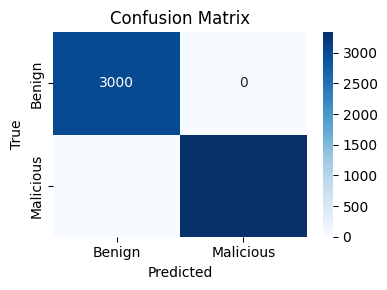

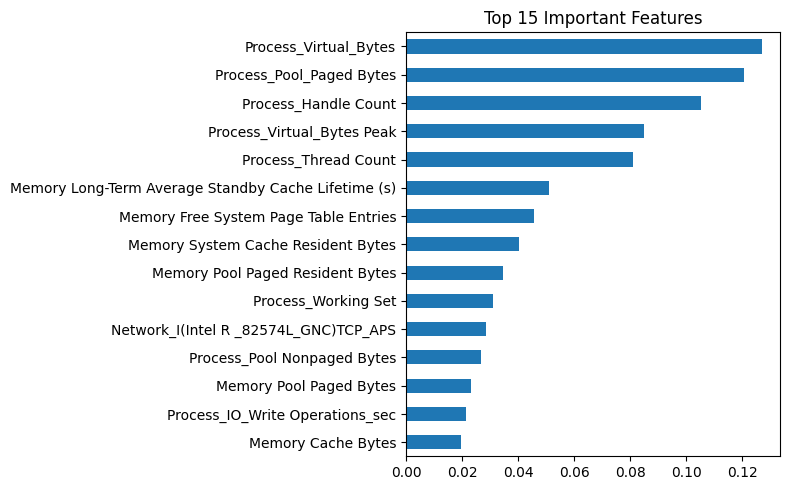

In [34]:
# 13 Alternate data set testing evaluation
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))
print("ROC AUC:", round(roc_auc_score(y_test, y_proba), 4))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign", "Malicious"],
            yticklabels=["Benign", "Malicious"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8,5))
imp.head(15).plot(kind="barh", title="Top 15 Important Features")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()